<script async src="https://www.googletagmanager.com/gtag/js?id=UA-59152712-8"></script>
<script>
  window.dataLayer = window.dataLayer || [];
  function gtag(){dataLayer.push(arguments);}
  gtag('js', new Date());

  gtag('config', 'UA-59152712-8');
</script>

# Testing Piecewise Polytropic EOS
## Author: Leo Werneck

<a id='toc'></a>

# Table of Contents
$$\label{toc}$$

This module is organized as follows

1. [Step 1](#introduction): **Introduction**
1. [Step 2](#plugging_in_values): **Plugging in some values**
1. [Step 3](#p_cold): **Taking a look at $P_{\rm cold}$**
    1. [Step 3.a](#p_cold__computing): *A function to evaluate $P_{\rm cold}$ based on `IllinoisGRMHD`*
    1. [Step 3.b](#p_cold__plotting): *Plotting $P_{\rm cold}\left(\rho\right)$*
1. [Step 4](#eps_cold): **Taking a look at $\epsilon_{\rm cold}$**
    1. [Step 4.a](#eps_cold__computing): *A function to evaluate $\epsilon_{\rm cold}$ based on `IllinoisGRMHD`*
    1. [Step 4.b](#eps_cold__plotting): *Plotting $\epsilon_{\rm cold}\left(\rho\right)$*
1. [Step 5](#ppeos__c_code): **The piecewise polytrope EOS C code**
    1. [Step 5.a](#ppeos__c_code__prelim): *Preliminary treatment of the input*
        1. [Step 5.a.i](#ppeos__c_code__prelim__computing_ktab): Determining $\left\{K_{1},K_{2},\ldots,K_{\rm neos}\right\}$
        1. [Step 5.a.ii](#ppeos__c_code__prelim__computing_eps_integ_consts): Determining $\left\{C_{0},C_{1},C_{2},\ldots,C_{\rm neos}\right\}$
    1. [Step 5.b](#ppeos__c_code__eos_struct_setup) *Setting up the `eos_struct`*
    1. [Step 5.c](#ppeos__c_code__find_polytropic_k_and_gamma_index) *The `find_polytropic_K_and_Gamma_index()` function*
    1. [Step 5.d](#ppeos__c_code__compute_P_cold__eps_cold__dPcold_drho__eps_th__h__Gamma_cold): *The new `compute_P_cold__eps_cold__dPcold_drho__eps_th__h__Gamma_cold()` function*
1. [Step n](#latex_pdf_output): **Output this notebook to $\LaTeX$-formatted PDF file**

<a id='introduction'></a>

# Step 1: Introduction \[Back to [top](#toc)\]
$$\label{introduction}$$

We will test here a few piecewise polytrope (PP) equation of state (EOS) relations. The main reference we will be following is [J.C. Read *et al.* (2008)](https://arxiv.org/pdf/0812.2163.pdf), but we will also try out [the approach of `Whisky`, presented in Takami *et al.* (2014)](https://arxiv.org/pdf/1412.3240v2.pdf)

First we will start with the original one implemented by IllinoisGRMHD:

$$
\boxed{
P_{\rm cold} =
\left\{
\begin{matrix}
K_{0}\rho^{\Gamma_{0}} & , & \rho \leq \rho_{0}\\
K_{1}\rho^{\Gamma_{1}} & , & \rho_{0} \leq \rho \leq \rho_{1}\\
\vdots &  & \vdots\\
K_{j}\rho^{\Gamma_{j}} & , & \rho_{j-1} \leq \rho \leq \rho_{j}\\
\vdots &  & \vdots\\
K_{N-1}\rho^{\Gamma_{N-1}} & , & \rho_{N-2} \leq \rho \leq \rho_{N-1}\\
K_{N}\rho^{\Gamma_{N}} & , & \rho \geq \rho_{N-1}
\end{matrix}
\right.
}\ .
$$

Notice that we have the following sets of variables:

$$
\left\{\underbrace{\rho_{0},\rho_{1},\ldots,\rho_{N-1}}_{N\ {\rm values}}\right\}\ ;\
\left\{\underbrace{K_{0},K_{1},\ldots,K_{N}}_{N+1\ {\rm values}}\right\}\ ;\
\left\{\underbrace{\Gamma_{0},\Gamma_{1},\ldots,\Gamma_{N}}_{N+1\ {\rm values}}\right\}\ .
$$

Also, notice that $K_{0}$ and the entire sets $\left\{\rho_{0},\rho_{1},\ldots,\rho_{N-1}\right\}$ and $\left\{\Gamma_{0},\Gamma_{1},\ldots,\Gamma_{N}\right\}$ must be specified by the user. The values of $\left\{K_{1},\ldots,K_{N}\right\}$, on the other hand, are determined by imposing that $P_{\rm cold}$ be continuous, i.e.

$$
P_{\rm cold}\left(\rho_{0}\right) = K_{0}\rho_{0}^{\Gamma_{0}} = K_{1}\rho_{0}^{\Gamma_{1}} \implies
\boxed{K_{1} = K_{0}\rho_{0}^{\Gamma_{0}-\Gamma_{1}}}\ .
$$

Analogously,

$$
\boxed{K_{j} = K_{j-1}\rho_{j-1}^{\Gamma_{j-1}-\Gamma_{j}}\ ,\ j\in\left[1,N\right]}\ .
$$

<a id='plugging_in_values'></a>

# Step 2: Plugging in some values \[Back to [top](#toc)\]
$$\label{plugging_in_values}$$

Just so that we work with realistic values (i.e. values actually used by researchers), we will implement a simple check using the values from [Table II in J.C. Read *et al.* (2008)](https://arxiv.org/pdf/0812.2163.pdf):

| $\rho_{i}$ | $\Gamma_{i}$ | $K_{\rm expected}$ |
|------------|--------------|--------------------|
|2.44034e+07 |   1.58425    |    6.80110e-09     |
|3.78358e+11 |   1.28733    |    1.06186e-06     |
|2.62780e+12 |   0.62223    |    5.32697e+01     |
|     $-$    |   1.35692    |    3.99874e-08     |

In [1]:
# Determining K_{i} i != 0
# We start by setting up all the values of rho_{i}, Gamma_{i}, and K_{0}
import numpy as np
rho_ppoly_tab   = [2.44034e+07,3.78358e+11,2.62780e+12]
Gamma_ppoly_tab = [1.58425,1.28733,0.62223,1.35692]
K_ppoly_tab     = [6.80110e-09,0,0,0]
K_expected = [6.80110e-09,1.06186e-06,5.32697e+01,3.99874e-08]
NEOS = len(rho_ppoly_tab)+1

for j in range(1,NEOS):
    K_ppoly_tab[j] = K_ppoly_tab[j-1] * rho_ppoly_tab[j-1]**(Gamma_ppoly_tab[j-1] - Gamma_ppoly_tab[j])
    print("K_ppoly_tab["+str(j)+"] = "+str(K_ppoly_tab[j])+\
          " | K_expected["+str(j)+"] = "+str(K_expected[j])+\
          " | Diff = "+str(np.fabs(K_ppoly_tab[j] - K_expected[j])))

K_ppoly_tab[1] = 1.0618444833278535e-06 | K_expected[1] = 1.06186e-06 | Diff = 1.5516672146434653e-11
K_ppoly_tab[2] = 53.2750845839615 | K_expected[2] = 53.2697 | Diff = 0.005384583961500766
K_ppoly_tab[3] = 3.999206917243191e-08 | K_expected[3] = 3.99874e-08 | Diff = 4.669172431909315e-12


<a id='p_cold'></a>

# Step 3: Taking a look at $P_{\rm cold}$ \[Back to [top](#toc)\]
$$\label{p_cold}$$

<a id='p_cold__computing'></a>

## Step 3.a: A function to evaluate $P_{\rm cold}$ based on `IllinoisGRMHD` \[Back to [top](#toc)\]
$$\label{p_cold__computing}$$

The results above look reasonable to the expected ones. Let us then see what the plot of $P_{\rm cold}\times\rho$ looks like. For the case of our specific example, which has $N_{\rm EOS}=4$ (where $N_{\rm EOS}$ stands for the number of polytropic EOSs used), we have

$$
\boxed{
P_{\rm cold} =
\left\{
\begin{matrix}
K_{0}\rho^{\Gamma_{0}} & , & \rho \leq \rho_{0}\\
K_{1}\rho^{\Gamma_{1}} & , & \rho_{0} \leq \rho \leq \rho_{1}\\
K_{2}\rho^{\Gamma_{2}} & , & \rho_{1} \leq \rho \leq \rho_{2}\\
K_{3}\rho^{\Gamma_{3}} & , & \rho \geq \rho_{2}
\end{matrix}
\right.
}\ .
$$

In [2]:
# Set the pressure through the polytropic EOS: P_cold = K * rho^{Gamma}
def P_cold(rho,rho_ppoly_tab,Gamma_ppoly_tab,K_ppoly_tab,NEOS):
    if rho < rho_ppoly_tab[0] or NEOS==1:
        return K_ppoly_tab[0] * rho**Gamma_ppoly_tab[0]
    
    if NEOS > 2:
        for j in range(1,NEOS-1):
            if rho_ppoly_tab[j-1] <= rho and rho < rho_ppoly_tab[j]:
                return K_ppoly_tab[j] * rho**Gamma_ppoly_tab[j]
        
    if rho >= rho_ppoly_tab[NEOS-2]:
        return K_ppoly_tab[NEOS-1] * rho**Gamma_ppoly_tab[NEOS-1]

<a id='p_cold__plotting'></a>

## Step 3.b: Plotting $P_{\rm cold}\left(\rho\right)$ \[Back to [top](#toc)\]
$$\label{p_cold__plotting}$$

To create a reasonably interesting plot, which will also test all regions of our piecewise polytrope EOS, let us plot $P_{\rm cold}\left(\rho\right)$ with $\rho\in\left[\frac{\rho_{0}}{10},10\rho_{2}\right]$.

**Remember**: We *don't* expect $P_{\rm cold}$ to be *smooth*, but we *do* expect it to be *continuous* (by construction).

In [3]:
# Set rho in [rho_ppoly_tab[0]/10,rho_ppoly_tab[2]*10]
rho_for_plot = np.linspace(rho_ppoly_tab[0]/10,rho_ppoly_tab[NEOS-2]*10,1000)

# Set P_{cold}(rho)
P_for_plot   = np.linspace(0,0,1000)
for i in range(len(P_for_plot)):
    P_for_plot[i] = P_cold(rho_for_plot[i],rho_ppoly_tab,Gamma_ppoly_tab,K_ppoly_tab,NEOS)

# Plot P_{cold}(rho) x rho
import matplotlib.pyplot as plt
f = plt.figure(figsize=(10,4))
ax1 = f.add_subplot(121)
ax1.set_title(r"Plot #1: $P_{\rm cold}\times\rho_{b}$",fontsize='16')
ax1.set_xlabel(r"$\rho_{b}$",fontsize='14')
ax1.set_ylabel(r"$P_{\rm cold}$",fontsize='14')
ax1.grid()
ax1.plot(rho_for_plot,P_for_plot)

ax2 = f.add_subplot(122)
ax2.set_title(r"Plot #2: $\log_{10}\left(P_{\rm cold}\right)\times\log_{10}\left(\rho_{b}\right)$",fontsize='16')
ax2.set_xlabel(r"$\log_{10}\left(\rho_{b}\right)$",fontsize='14')
ax2.set_ylabel(r"$\log_{10}\left(P_{\rm cold}\right)$",fontsize='14')
ax2.grid()
ax2.plot(np.log10(rho_for_plot),np.log10(P_for_plot))

<a id='eps_cold'></a>

# Step 4: Taking a look at $\epsilon_{\rm cold}$ \[Back to [top](#toc)\]
$$\label{eps_cold}$$

$\epsilon_{\rm cold}$ is determined via

$$
\epsilon_{\rm cold} = \int d\rho\, \frac{P_{\rm cold}}{\rho^{2}} \ ,
$$

for some integration constant $C$. **Notation alert**: in the literature, the integration constants $C_{j}$ below are usually called $\epsilon_{j}$. We will keep them as $C_{j}$ for a clearer exposition.

In the case of a piecewise polytropic EOS, we then must have

$$
\boxed{
\epsilon_{\rm cold} = 
\left\{
\begin{matrix}
\frac{K_{0}\rho^{\Gamma_{0}-1}}{\Gamma_{0}-1} + C_{0} & , & \rho \leq \rho_{0}\\
\frac{K_{1}\rho^{\Gamma_{1}-1}}{\Gamma_{1}-1} + C_{1} & , & \rho_{0} \leq \rho \leq \rho_{1}\\
\vdots &  & \vdots\\
\frac{K_{j}\rho^{\Gamma_{j}-1}}{\Gamma_{j}-1} + C_{j} & , & \rho_{j-1} \leq \rho \leq \rho_{j}\\
\vdots &  & \vdots\\
\frac{K_{N-1}\rho^{\Gamma_{N-1}-1}}{\Gamma_{N-1}-1} + C_{N-1} & , & \rho_{N-2} \leq \rho \leq \rho_{N-1}\\
\frac{K_{N}\rho^{\Gamma_{N}-1}}{\Gamma_{N}-1} + C_{N} & , & \rho \geq \rho_{N-1}
\end{matrix}
\right.
}\ .
$$

We fix $C_{0}$ by demanding that $\epsilon_{\rm cold}\left(\rho=0\right) = 0$. Then, continuity of $\epsilon_{\rm cold}$ imposes that

$$
\frac{K_{0}\rho_{0}^{\Gamma_{0}-1}}{\Gamma_{0}-1} = \frac{K_{1}\rho_{0}^{\Gamma_{1}-1}}{\Gamma_{1}-1} + C_{1}\implies \boxed{C_{1} = \frac{K_{0}\rho_{0}^{\Gamma_{0}-1}}{\Gamma_{0}-1} - \frac{K_{1}\rho_{0}^{\Gamma_{1}-1}}{\Gamma_{1}-1}}\ ,
$$

for $C_{1}$ and

$$
\boxed{C_{j} = C_{j-1} + \frac{K_{j-1}\rho_{j-1}^{\Gamma_{j-1}-1}}{\Gamma_{j-1}-1} - \frac{K_{j}\rho_{j-1}^{\Gamma_{j}-1}}{\Gamma_{j}-1}\ ,\ j\geq1}\ ,
$$

generically.

<a id='eps_cold__computing'></a>

## Step 4.a: *A function to evaluate $\epsilon_{\rm cold}$ based on `IllinoisGRMHD`* \[Back to [top](#toc)\]
$$\label{eps_cold__computing}$$

We continue with our previous values of the piecewise polytrope EOS, for which we will have

$$
\boxed{
\epsilon_{\rm cold} = 
\left\{
\begin{matrix}
\frac{K_{0}\rho^{\Gamma_{0}-1}}{\Gamma_{0}-1} & , & \rho \leq \rho_{0}\\
\frac{K_{1}\rho^{\Gamma_{1}-1}}{\Gamma_{1}-1} + C_{1} & , & \rho_{0} \leq \rho \leq \rho_{1}\\
\frac{K_{2}\rho^{\Gamma_{2}-1}}{\Gamma_{2}-1} + C_{2} & , & \rho_{1} \leq \rho \leq \rho_{2}\\
\frac{K_{3}\rho^{\Gamma_{3}-1}}{\Gamma_{3}-1} + C_{3} & , & \rho \geq \rho_{2}
\end{matrix}
\right.
}\ ,
$$

remembering that the integration constants are set via

$$
\boxed{
C_{j} =
\left\{
\begin{matrix}
0 & , & {\rm if}\ j=0\\
C_{j-1} + \frac{K_{j-1}\rho_{j-1}^{\Gamma_{j-1}-1}}{\Gamma_{j-1}-1} - \frac{K_{j}\rho_{j-1}^{\Gamma_{j}-1}}{\Gamma_{j}-1} & , & {\rm otherwise}
\end{matrix}
\right.
}\ .
$$

In [4]:
# Setting eps_cold
def eps_cold__integration_constants(rho_ppoly_tab,Gamma_ppoly_tab,K_ppoly_tab,NEOS):
    if NEOS == 1:
        eps_integ_consts[0] = 0
        return eps_integ_consts
    
    eps_integ_consts = [0 for i in range(NEOS)]
    for j in range(1,NEOS):
        aux_jm1 = K_ppoly_tab[j-1] * rho_ppoly_tab[j-1]**(Gamma_ppoly_tab[j-1]-1) / (Gamma_ppoly_tab[j-1]-1)
        aux_jp0 = K_ppoly_tab[j+0] * rho_ppoly_tab[j-1]**(Gamma_ppoly_tab[j+0]-1) / (Gamma_ppoly_tab[j+0]-1)
        eps_integ_consts[j] = eps_integ_consts[j-1] + aux_jm1 - aux_jp0

    return eps_integ_consts

def eps_cold(rho,rho_ppoly_tab,Gamma_ppoly_tab,K_ppoly_tab,NEOS):
    if rho < rho_ppoly_tab[0] or NEOS==1:
        return K_ppoly_tab[0] * rho**(Gamma_ppoly_tab[0]-1) / (Gamma_ppoly_tab[0]-1)
    
    # Compute C_{j}
    eps_integ_consts = eps_cold__integration_constants(rho_ppoly_tab,Gamma_ppoly_tab,K_ppoly_tab,NEOS)
    
    # Compute eps_cold for rho >= rho_{0}
    if NEOS>2:
        for j in range(1,NEOS-1):
            if rho >= rho_ppoly_tab[j-1] and rho < rho_ppoly_tab[j]:
                return eps_integ_consts[j] + K_ppoly_tab[j] * rho**(Gamma_ppoly_tab[j]-1) / (Gamma_ppoly_tab[j]-1)
        
    if rho >= rho_ppoly_tab[NEOS-2]:
        return eps_integ_consts[NEOS-1] + K_ppoly_tab[NEOS-1] * rho**(Gamma_ppoly_tab[NEOS-1]-1) / (Gamma_ppoly_tab[NEOS-1]-1)

<a id='eps_cold__plotting'></a>

## Step 4.b: Plotting $\epsilon_{\rm cold}$ \[Back to [top](#toc)\]
$$\label{eps_cold__plotting}$$

To create a reasonably interesting plot, which will also test all regions of our piecewise polytrope EOS, let us plot $\epsilon_{\rm cold}\left(\rho\right)$ with $\rho\in\left[\frac{\rho_{0}}{10},10\rho_{2}\right]$.

**Remember**: We *don't* expect $\epsilon_{\rm cold}$ to be *smooth*, but we *do* expect it to be *continuous* (by construction).

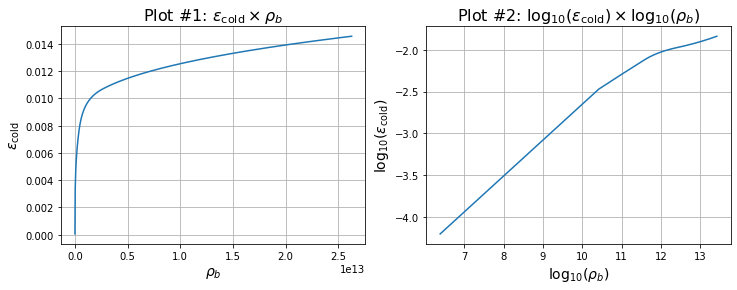

In [5]:
# Set rho in [rho_ppoly_tab[0]/10,rho_ppoly_tab[2]*10]
rho_for_plot = np.linspace(rho_ppoly_tab[0]/10,rho_ppoly_tab[NEOS-2]*10,1000)

# Set P_{cold}(rho)
eps_for_plot = np.linspace(0,0,1000)
for i in range(len(eps_for_plot)):
    eps_for_plot[i] = eps_cold(rho_for_plot[i],rho_ppoly_tab,Gamma_ppoly_tab,K_ppoly_tab,NEOS)

# Plot P_{cold}(rho) x rho
import matplotlib.pyplot as plt
f = plt.figure(figsize=(12,4))
ax1 = f.add_subplot(121)
ax1.set_title(r"Plot #1: $\varepsilon_{\rm cold}\times\rho_{b}$",fontsize='16')
ax1.set_xlabel(r"$\rho_{b}$",fontsize='14')
ax1.set_ylabel(r"$\varepsilon_{\rm cold}$",fontsize='14')
ax1.grid()
ax1.plot(rho_for_plot,eps_for_plot)

ax2 = f.add_subplot(122)
ax2.set_title(r"Plot #2: $\log_{10}\left(\varepsilon_{\rm cold}\right)\times\log_{10}\left(\rho_{b}\right)$",fontsize='16')
ax2.set_xlabel(r"$\log_{10}\left(\rho_{b}\right)$",fontsize='14')
ax2.set_ylabel(r"$\log_{10}\left(\varepsilon_{\rm cold}\right)$",fontsize='14')
ax2.grid()
ax2.plot(np.log10(rho_for_plot),np.log10(eps_for_plot))

<a id='ppeos__c_code'></a>

# Step 5: The piecewise polytrope EOS C code \[Back to [top](#toc)\]
$$\label{ppeos__c_code}$$

Now we will begin implementing a C code to handle all the topics we discussed here.

<a id='ppeos__c_code__prelim'></a>

## Step 5.a: Preliminary treatment of the input \[Back to [top](#toc)\]
$$\label{ppeos__c_code__prelim}$$

Here we assume that we get as input the following values:

1. neos: the number of polytropic EOSs we will be handling (equivalent to $N+1$ in the discussion above)
1. rho_ppoly_tab: an array containing the values $\left\{\rho_{0},\rho_{1},\ldots,\rho_{{\rm neos}-1}\right\}$. Notice that for both neos=1 and neos=2, the size of this array is $1$.
1. K_ppoly_tab: an array of size neos containing only the value of $K_{0}$ in the entry K_ppoly_tab[0].
1. Gamma_ppoly_tab: an array of size neos containing the values $\left\{\Gamma_{0},\Gamma_{1},\ldots,\Gamma_{N}\right\}$.

In [6]:
import os,sys
IGM_src_dir = os.path.join("..","src")
Piecewise_Polytrope_EOS__C = os.path.join(IGM_src_dir,"IllinoisGRMHD_EoS_lowlevel_functs.C")

In [7]:
%%writefile $Piecewise_Polytrope_EOS__C
#ifndef ILLINOISGRMHD_EOS_FUNCTS_C_
#define ILLINOISGRMHD_EOS_FUNCTS_C_
/* Function    : setup_K_ppoly_tab__and__eps_integ_consts()
 * Authors     : Leo Werneck
 * Description : For a given set of EOS inputs, determine
 *               values of K_ppoly_tab that will result in a
 *               everywhere continuous P_cold function.
 * Dependencies: none
 *
 * Inputs      : eos             - a struct containing the following
 *                                 relevant quantities:
 *             : neos            - number of polytropic EOSs used
 *             : rho_ppoly_tab   - array of rho values that determine
 *                                 the polytropic EOS to be used.
 *             : Gamma_ppoly_tab - array of Gamma_cold values to be
 *                                 used in each polytropic EOS.
 *             : K_ppoly_tab     - array of K_ppoly_tab values to be used
 *                                 in each polytropic EOS. Only K_ppoly_tab[0]
 *                                 is known prior to the function call
 *             : eps_integ_const - array of C_{j} values, which are the
 *                                 integration constants that arrise when
 *                                 determining eps_{cold} for a piecewise
 *                                 polytropic EOS. This array should be
 *                                 uninitialized or contain absurd values
 *                                 prior to this function call.
 *
 * Outputs     : K_ppoly_tab     - fully populated array of K_ppoly_tab
 *                                 to be used in each polytropic EOS.
 *             : eps_integ_const - fully populated array of C_{j}'s,
 *                                 used to compute eps_cold for
 *                                 a piecewise polytropic EOS.
 */
static void setup_K_ppoly_tab__and__eps_integ_consts(eos_struct &eos){

Overwriting ../src/IllinoisGRMHD_EoS_lowlevel_functs.C


<a id='ppeos__c_code__prelim__computing_ktab'></a>

### Step 5.a.i: Determining $\left\{K_{1},K_{2},\ldots,K_{\rm neos}\right\}$ \[Back to [top](#toc)\]
$$\label{ppeos__c_code__prelim__computing_ktab}$$

We start by computing the values $\left\{K_{1},K_{2},\ldots,K_{\rm neos}\right\}$ from the input values. Remember that the values of $K_{j}$ are obtained by demanding that the $P_{\rm cold}$ function be everywhere continuous, resulting in the relation (see [the discussion above for the details](#introduction))

$$
\boxed{K_{j} = K_{j-1}\rho_{j-1}^{\Gamma_{j-1}-\Gamma_{j}}\ ,\ j\in\left[1,N\right]}\ .
$$

**Implementation note**: Because the case neos=1 is handled first, the attentive reader will notice that we already set $C_{0}=0$ below, *before* discussing its implementation. For more on that, please refer to the [next subsection, where we discuss determining $\left\{C_{0},C_{1},C_{2},\ldots,C_{\rm neos}\right\}$](#ppeos__c_code__prelim__computing_eps_integ_consts).

In [8]:
%%writefile -a $Piecewise_Polytrope_EOS__C

  /* When neos = 1, we will only need the value K_ppoly_tab[0] and eps_integ_const[0].
   * Since our only polytropic EOS is given by
   *  -----------------------------------
   * | P_{0} = K_{0} * rho ^ (Gamma_{0}) | ,
   *  -----------------------------------
   * and, therefore,
   *  ---------------------------------------------------------------
   * | eps_{0} = K_{0} * rho ^ (Gamma_{0}-1) / (Gamma_{0}-1) + C_{0} | ,
   *  ---------------------------------------------------------------
   * we only need to set up K_{0} := K_ppoly_tab[0] and C_{0} := eps_integ_const[0].
   * K_{0} is a user input, so we need to do nothing. C_{0}, on the other hand,
   * is fixed by demanding that eps(rho) -> 0 as rho -> 0. Thus, C_{0} = 0.
   */
  eos.eps_integ_const[0] = 0.0;
  if(eos.neos==1) return;

  /********************
   * Setting up K_{j} *
   ********************/
  /* When neos > 1, we have the following structure
   *
   *           /      K_{0} * rho^(Gamma_{0})      ,                 rho <  rho_{0}
   *           |      K_{1} * rho^(Gamma_{1})      ,      rho_{0} <= rho <  rho_{1}
   *           |              ...
   * P(rho) = <       K_{j} * rho^(Gamma_{j})      ,    rho_{j-1} <= rho <  rho_{j}
   *           |              ...
   *           | K_{neos-2} * rho^(Gamma_{neos-2}) , rho_{neos-3} <= rho <  rho_{neos-2}
   *           \ K_{neos-1} * rho^(Gamma_{neos-1}) ,                 rho >= rho_{neos-2}
   *
   * Imposing that P(rho) be everywhere continuous, we have
   *  -------------------------------------------------
   * | K_{j} = K_{j-1} * rho^(Gamma_{j-1} - Gamma_{j}) |
   *  -------------------------------------------------
   */
  for(int j=1; j<eos.neos; j++){
    // Set a useful auxiliary variable to keep things more compact:
    // First, (Gamma_{j-1} - Gamma_{j}):
    CCTK_REAL Gamma_diff = eos.Gamma_ppoly_tab[j-1] - eos.Gamma_ppoly_tab[j];

    // Implement the boxed equation above, using our auxiliary variable:
    eos.K_ppoly_tab[j] = eos.K_ppoly_tab[j-1] * pow(eos.rho_ppoly_tab[j-1],Gamma_diff);
  }



Appending to ../src/IllinoisGRMHD_EoS_lowlevel_functs.C


<a id='ppeos__c_code__prelim__computing_eps_integ_consts'></a>

### Step 5.a.ii: Determining $\left\{C_{0},C_{1},C_{2},\ldots,C_{\rm neos}\right\}$ \[Back to [top](#toc)\]
$$\label{ppeos__c_code__prelim__computing_eps_integ_consts}$$

We now focus our attention to the computation of $\left\{C_{0},C_{1},C_{2},\ldots,C_{\rm neos}\right\}$, which are the integration constants that emerge when computing $\epsilon_{\rm cold}$ for a piecewise polytrope EOS (see [the discussion above for the details](#eps_cold)). Here we set them so that $\epsilon_{\rm cold}$ is also everywhere continuous, i.e.

$$
\boxed{
C_{j} =
\left\{
\begin{matrix}
0 & , & {\rm if}\ j=0\\
C_{j-1} + \frac{K_{j-1}\rho_{j-1}^{\Gamma_{j-1}-1}}{\Gamma_{j-1}-1} - \frac{K_{j}\rho_{j-1}^{\Gamma_{j}-1}}{\Gamma_{j}-1} & , & {\rm otherwise}
\end{matrix}
\right.
}\ .
$$

In [9]:
%%writefile -a $Piecewise_Polytrope_EOS__C

  /********************
   * Setting up C_{j} *
   ********************/
  /* When neos > 1, we have the following structure (let neos->N):
   *
   *             /      K_{0}*rho^(Gamma_{0}-1)/(Gamma_{0}-1)  + C_{0},                rho <  rho_{0}
   *             |      K_{1}*rho^(Gamma_{1}-1)/(Gamma_{1}-1)  + C_{1},     rho_{0} <= rho <  rho_{1}
   *             |                     ...
   * eps(rho) = <       K_{j}*rho^(Gamma_{j}-1)/(Gamma_{j}-1)  + C_{j},   rho_{j-1} <= rho <  rho_{j}
   *             |                     ...
   *             | K_{N-2}*rho^(Gamma_{N-2}-1)/(Gamma_{N-2}-1) + C_{N-2}, rho_{N-3} <= rho <  rho_{N-2}
   *             \ K_{N-1}*rho^(Gamma_{N-1}-1)/(Gamma_{N-1}-1) + C_{N-1},              rho >= rho_{N-2}
   *
   * Imposing that eps_{cold}(rho) be everywhere continuous, we have
   *  ---------------------------------------------------------------
   * | C_{j} = C_{j-1}                                               |
   * |       + ( K_{j-1}*rho_{j-1}^(Gamma_{j-1}-1) )/(Gamma_{j-1}-1) |
   * |       - ( K_{j+0}*rho_{j-1}^(Gamma_{j+0}-1) )/(Gamma_{j+0}-1) |
   *  ---------------------------------------------------------------
   */
  for(int j=1; j<eos.neos; j++){
    // Set a few useful auxiliary variables to keep things more compact:
    // First, (Gamma_{j-1}-1):
    CCTK_REAL Gammajm1m1 = eos.Gamma_ppoly_tab[j-1] - 1.0;

    // Then, (Gamma_{j+0}-1):
    CCTK_REAL Gammajp0m1 = eos.Gamma_ppoly_tab[j+0] - 1.0;

    // Next, ( K_{j-1}*rho_{j-1}^(Gamma_{j-1}-1) )/(Gamma_{j-1}-1):
    CCTK_REAL aux_epsm1  = eos.K_ppoly_tab[j-1]*pow(eos.rho_ppoly_tab[j-1],Gammajm1m1)/Gammajm1m1;

    // Finally, ( K_{j+0}*rho_{j+0}^(Gamma_{j+0}-1) )/(Gamma_{j+0}-1):
    CCTK_REAL aux_epsp0  = eos.K_ppoly_tab[j+0]*pow(eos.rho_ppoly_tab[j-1],Gammajp0m1)/Gammajp0m1;

    // Implement the boxed equation above, using our auxiliary variables:
    eos.eps_integ_const[j] = eos.eps_integ_const[j-1] + aux_epsm1 - aux_epsp0;
  }
}



Appending to ../src/IllinoisGRMHD_EoS_lowlevel_functs.C


<a id='ppeos__c_code__eos_struct_setup'></a>

## Step 5.b: Setting up the `eos_struct` \[Back to [top](#toc)\]
$$\label{ppeos__c_code__eos_struct_setup}$$

We will now set up the `eos_struct` from input. The `eos_struct` declaration can be found inside the `IllinoisGRMHD_headers.h` source file, but we will repeat it here for the sake of the reader:

```c
#define MAX_EOS_PARAMS 10
struct eos_struct {
  int neos;
  CCTK_REAL rho_ppoly_tab[MAX_EOS_PARAMS-1];
  CCTK_REAL eps_integ_const[MAX_EOS_PARAMS],K_ppoly_tab[MAX_EOS_PARAMS],Gamma_ppoly_tab[MAX_EOS_PARAMS];
  CCTK_REAL Gamma_th;
};
```

In [10]:
%%writefile -a $Piecewise_Polytrope_EOS__C

/* Function    : initialize_EOS_struct_from_input()
 * Authors     : Leo Werneck
 * Description : Initialize the eos struct from user
 *               input
 * Dependencies: setup_K_ppoly_tab__and__eps_integ_consts()
 *             : cctk_parameters.h (FIXME)
 *
 * Inputs      : eos             - a struct containing the following
 *                                 relevant quantities:
 *             : neos            - number of polytropic EOSs used
 *             : rho_ppoly_tab   - array of rho values that determine
 *                                 the polytropic EOS to be used.
 *             : Gamma_ppoly_tab - array of Gamma_cold values to be
 *                                 used in each polytropic EOS.
 *             : K_ppoly_tab     - array of K_ppoly_tab values to be used
 *                                 in each polytropic EOS.
 *             : eps_integ_const - array of C_{j} values, which are the
 *                                 integration constants that arrise when
 *                                 determining eps_{cold} for a piecewise
 *                                 polytropic EOS.
 *
 * Outputs     : eos             - fully initialized EOS struct
 */
static void initialize_EOS_struct_from_input(eos_struct &eos){
    /* We start by setting up the eos_struct
     * with the inputs given by the user at
     * the start of the simulation. Keep in
     * mind that these parameters are found
     * in the "cctk_parameters.h" header file.
     *        ^^^^^^^FIXME^^^^^^^
     */

    // Initialize: neos, {rho_{j}}, {K_{0}}, and {Gamma_{j}}
#ifndef ENABLE_STANDALONE_IGM_C2P_SOLVER
    DECLARE_CCTK_PARAMETERS;
#endif

    eos.neos = neos;
    eos.K_ppoly_tab[0] = K_ppoly_tab0;
    for(int j=0; j<=neos-2; j++) eos.rho_ppoly_tab[j]   = rho_ppoly_tab_in[j];
    for(int j=0; j<=neos-1; j++) eos.Gamma_ppoly_tab[j] = Gamma_ppoly_tab_in[j];
    
    // Initialize {K_{j}}, j>=1, and {eps_integ_const_{j}}
    setup_K_ppoly_tab__and__eps_integ_consts(eos);
}



Appending to ../src/IllinoisGRMHD_EoS_lowlevel_functs.C


<a id='ppeos__c_code__find_polytropic_k_and_gamma_index'></a>

## Step 5.c: The `find_polytropic_K_and_Gamma_index()` function \[Back to [top](#toc)\]
$$\label{ppeos__c_code__find_polytropic_k_and_gamma_index}$$

In [11]:
%%writefile -a $Piecewise_Polytrope_EOS__C

/* Function    : find_polytropic_K_and_Gamma_index()
 * Authors     : Leo Werneck & Zach Etienne
 * Description : For a given value of rho, find the
 *               appropriate values of Gamma_ppoly_tab
 *               and K_ppoly_tab by determining the appropriate
 *               index
 * Dependencies: initialize_EOS_struct_from_input()
 *             : cctk_parameters.h (FIXME)
 *
 * Inputs      : eos           - a struct containing the following
 *                               relevant quantities:
 *             : neos          - number of polytropic EOSs used
 *             : rho_ppoly_tab - array of rho values that determine
 *
 * Outputs     : index         - the appropriate index for the K_ppoly_tab
 *                               and Gamma_ppoly_tab array
 */
static inline int find_polytropic_K_and_Gamma_index(eos_struct eos, CCTK_REAL rho_in) {
  
   /* We want to find the appropriate polytropic EOS for the
    * input value rho_in. Remember that:
    *
    * if rho < rho_{0}:                P_{0} , index: 0
    * if rho >= rho_{0} but < rho_{1}: P_{1} , index: 1
    * if rho >= rho_{1} but < rho_{2}: P_{2} , index: 2
    *                      ...
    * if rho >= rho_{j-1} but < rho_{j}: P_{j} , index: j
    *
    * Then, a simple way of determining the index is through
    * the formula:
    *  ---------------------------------------------------------------------------
    * | index = (rho >= rho_{0}) + (rho >= rho_{1}) + ... + (rho >= rho_{neos-2}) |
    *  ---------------------------------------------------------------------------
    */
    if(eos.neos == 1) return 0;
    
    int polytropic_index = 0;
    for(int j=0; j<=eos.neos-2; j++) polytropic_index += (rho_in >= eos.rho_ppoly_tab[j]);
    
    return polytropic_index;
}



Appending to ../src/IllinoisGRMHD_EoS_lowlevel_functs.C


In [12]:
%%writefile -a $Piecewise_Polytrope_EOS__C

/* Function    : compute_P_cold__eps_cold()
 * Authors     : Leo Werneck
 * Description : Computes P_cold and eps_cold.
 * Dependencies: initialize_EOS_struct_from_input()
 *             : find_polytropic_K_and_Gamma_index()
 *
 * Inputs      : P_cold           - cold pressure
 *             : eps_cold         - cold specific internal energy
 *             : eos              - a struct containing the following
 *                                  relevant quantities:
 *             : neos             - number of polytropic EOSs used
 *             : rho_ppoly_tab         - array of rho values that determine
 *                                  the polytropic EOS to be used.
 *             : Gamma_ppoly_tab       - array of Gamma_cold values to be
 *                                  used in each polytropic EOS.
 *             : K_ppoly_tab           - array of K_ppoly_tab values to be used
 *                                  in each polytropic EOS.
 *             : eps_integ_const  - array of C_{j} values, which are the
 *                                  integration constants that arrise when
 *                                  determining eps_{cold} for a piecewise
 *                                  polytropic EOS.
 *
 * Outputs     : P_cold           - cold pressure (supports SPEOS and PPEOS)
 *             : eps_cold         - cold specific internal energy (supports SPEOS and PPEOS)
 *             : polytropic_index - polytropic index used for P_cold and eps_cold
 *
 *             SPEOS: Single-Polytrope Equation of State
 *             PPEOS: Piecewise Polytrope Equation of State
 */
static inline void compute_P_cold__eps_cold(eos_struct eos, CCTK_REAL rho_in,
                                            CCTK_REAL &P_cold,CCTK_REAL &eps_cold) {
  // This code handles equations of state of the form defined
  // in Eqs 13-16 in http://arxiv.org/pdf/0802.0200.pdf
  if(rho_in==0) {
    P_cold   = 0.0;
    eps_cold = 0.0;
    return;
  }
    
  /*  --------------------------------------------------
   * | Single and Piecewise Polytropic EOS modification |
   *  --------------------------------------------------
   *
   * We now begin our modifications to this function so that
   * it supports both single and piecewise polytropic equations
   * of state.
   *
   * The modifications below currently assume that the user
   * has called the recently added function
   *
   * - initialize_EOS_struct_from_input()
   *
   * *before* this function is called. We can add some feature
   * to check this automatically as well, but we'll keep that as
   * a TODO/FIXME for now.
   */

  /* First, we compute the pressure, which in the case of a
   * piecewise polytropic EOS is given by
   *
   *           /   P_{1}      /    K_{1} * rho^(Gamma_{1})       ,      rho_{0} <= rho < rho_{1}
   *           |    ...       |            ...
   * P(rho) = <    P_{j}   = <     K_{j} * rho^(Gamma_{j})       ,    rho_{j-1} <= rho < rho_{j}
   *           |    ...       |            ...
   *           \ P_{neos-2}   \ K_{neos-2} * rho^(Gamma_{neos-2}), rho_{neos-3} <= rho < rho_{neos-2}
   *
   * The index j is determined by the find_polytropic_K_and_Gamma_index() function.
   */
  // Set up useful auxiliary variables
  int polytropic_index      = find_polytropic_K_and_Gamma_index(eos,rho_in);
  CCTK_REAL K_ppoly_tab     = eos.K_ppoly_tab[polytropic_index];
  CCTK_REAL Gamma_ppoly_tab = eos.Gamma_ppoly_tab[polytropic_index];
  CCTK_REAL eps_integ_const = eos.eps_integ_const[polytropic_index];
    
  // Then compute P_{cold}
  P_cold = K_ppoly_tab*pow(rho_in,Gamma_ppoly_tab);
    
  /* Then we compute the cold component of the specific internal energy,
   * which in the case of a piecewise polytropic EOS is given by (neos -> N)
   *
   *             /   P_{1}/(rho*(Gamma_{1}-1))   + C_{1}  ,   rho_{0} <= rho < rho_{1}
   *             |                     ...
   * eps(rho) = <    P_{j}/(rho*(Gamma_{j}-1))   + C_{j}  , rho_{j-1} <= rho < rho_{j}
   *             |                     ...
   *             \ P_{N-2}/(rho*(Gamma_{N-2}-1)) + C_{N-2}, rho_{N-3} <= rho < rho_{N-2}
   */
  eps_cold = P_cold/(rho_in*(Gamma_ppoly_tab-1.0)) + eps_integ_const;

}



Appending to ../src/IllinoisGRMHD_EoS_lowlevel_functs.C


<a id='ppeos__c_code__compute_P_cold__eps_cold__dPcold_drho__eps_th__h__Gamma_cold'></a>

## Step 5.d: The new `compute_P_cold__eps_cold__dPcold_drho__eps_th__h__Gamma_cold()` function \[Back to [top](#toc)\]
$$\label{ppeos__c_code__compute_P_cold__eps_cold__dPcold_drho__eps_th__h__Gamma_cold}$$

We now write down the updated version of the `compute_P_cold__eps_cold__dPcold_drho__eps_th__h__Gamma_cold()` function, which is found in the `inlined_functions.C` source file of `IllinoisGRMHD`, and documented in the [`IllinoisGRMHD`'s inlined functions NRPy+ tutorial module](Tutorial-IllinoisGRMHD__inlined_functions.ipynb).

In [13]:
%%writefile -a $Piecewise_Polytrope_EOS__C

/* Function    : compute_P_cold__eps_cold__dPcold_drho__eps_th__h__Gamma_cold()
 * Authors     : Leo Werneck & Zach Etienne
 * Description : Compute basic quantities related to
 *             : the EOS, namely: P_cold, eps_cold,
 *             : dPcold/drho, eps_th, h, and Gamma_cold
 * Dependencies: initialize_EOS_struct_from_input()
 *
 * Inputs      : U               - array containing primitives {rho,P,v^{i},B^i}
 *             : P_cold          - cold pressure
 *             : eps_cold        - cold specific internal energy
 *             : dPcold_drho     - derivative of P_cold
 *             : eps_th          - thermal specific internal energy
 *             : h               - enthalpy
 *             : Gamma_cold      - cold polytropic Gamma
 *             : eos             - a struct containing the following
 *                                 relevant quantities:
 *             : neos            - number of polytropic EOSs used
 *             : rho_ppoly_tab   - array of rho values that determine
 *                                 the polytropic EOS to be used.
 *             : Gamma_ppoly_tab - array of Gamma_cold values to be
 *                                 used in each polytropic EOS.
 *             : K_ppoly_tab     - array of K_ppoly_tab values to be used
 *                                 in each polytropic EOS.
 *             : eps_integ_const - array of C_{j} values, which are the
 *                                 integration constants that arrise when
 *                                 determining eps_{cold} for a piecewise
 *                                 polytropic EOS.
 *
 * Outputs     : P_cold          - cold pressure (supports SPEOS and PPEOS)
 *             : eps_cold        - cold specific internal energy (supports SPEOS and PPEOS)
 *             : dPcold_drho     - derivative of P_cold (supports SPEOS and PPEOS)
 *             : eps_th          - thermal specific internal energy (supports SPEOS and PPEOS)
 *             : h               - enthalpy (supports SPEOS and PPEOS)
 *             : Gamma_cold      - cold polytropic Gamma (supports SPEOS and PPEOS)
 *
 *             SPEOS: Single-Polytrope Equation of State
 *             PPEOS: Piecewise Polytrope Equation of State
 */
static inline void compute_P_cold__eps_cold__dPcold_drho__eps_th__h__Gamma_cold(CCTK_REAL *U, eos_struct &eos, CCTK_REAL Gamma_th,
                                                                         CCTK_REAL &P_cold,CCTK_REAL &eps_cold,CCTK_REAL &dPcold_drho,CCTK_REAL &eps_th,CCTK_REAL &h,
                                                                         CCTK_REAL &Gamma_cold) {
  // This code handles equations of state of the form defined
  // in Eqs 13-16 in http://arxiv.org/pdf/0802.0200.pdf
    
  if(U[RHOB]==0) {
    P_cold      = 0.0;
    eps_cold    = 0.0;
    dPcold_drho = 0.0;
    eps_th      = 0.0;
    h           = 0.0;
    Gamma_cold  = eos.Gamma_ppoly_tab[0];
    return;
  }

  int polytropic_index = find_polytropic_K_and_Gamma_index(eos, U[RHOB]);
  compute_P_cold__eps_cold(eos,U[RHOB], P_cold,eps_cold);
  CCTK_REAL Gamma_ppoly_tab = eos.Gamma_ppoly_tab[polytropic_index];

  // Set auxiliary variable rho_b^{-1}
  CCTK_REAL U_RHOB_inv = 1.0/U[RHOB];

  // Next compute dP/drho = Gamma * P / rho
  dPcold_drho = Gamma_ppoly_tab*P_cold*U_RHOB_inv;

  // Then we compute eps_th, h, and set Gamma_cold = Gamma_ppoly_tab[j].
  eps_th = (U[PRESSURE] - P_cold)/(Gamma_th-1.0)*U_RHOB_inv;
  h = 1.0 + eps_cold + eps_th + U[PRESSURE]*U_RHOB_inv;
  Gamma_cold = Gamma_ppoly_tab;

}



Appending to ../src/IllinoisGRMHD_EoS_lowlevel_functs.C


<a id='ppeos__c_code__print_eos_table'></a>

## Step 5.e: The `print_EOS_table()` function \[Back to [top](#toc)\]
$$\label{ppeos__c_code__print_eos_table}$$

This function, which is called for diagnostic purposes and for user convenience, prints out the most relevant EOS table components to the user at the *beginning* of the run. Notice that the function call happens only once, in the [`driver_conserv_to_prims.C`](Tutorial-IllinoisGRMHD__the_conservative_to_primitive_algorithm.ipynb) file.

In [14]:
%%writefile -a $Piecewise_Polytrope_EOS__C

/* Function    : print_EOS_table()
 * Authors     : Leo Werneck
 * Description : Prints out the EOS table, for diagnostic purposes
 *
 * Dependencies: initialize_EOS_struct_from_input()
 *
 * Inputs      : eos             - a struct containing the following
 *                                 relevant quantities:
 *             : neos            - number of polytropic EOSs used
 *             : rho_ppoly_tab   - array of rho values that determine
 *                                 the polytropic EOS to be used.
 *             : Gamma_ppoly_tab - array of Gamma_cold values to be
 *                                 used in each polytropic EOS.
 *
 * Outputs     : CCTK_VInfo string with the EOS table used by IllinoisGRMHD
 */
static inline void print_EOS_table( eos_struct eos ) {

  /* Start by printint a header t the table */
#ifndef ENABLE_STANDALONE_IGM_C2P_SOLVER
  CCTK_VInfo(CCTK_THORNSTRING,"\n"
#else
  printf("\n"
#endif
".--------------------------------------------.\n"
"|                 EOS Table                  |\n"
".--------------------------------------------.");
  printf("|              rho_ppoly_tab[j]              |\n"
".--------------------------------------------.\n");
  
  /* Adjust the maximum index of rhob to 
   * allow for single polytropes as well
   */
  int max_rho_index;
  if( eos.neos==1 ) {
    max_rho_index = 0;
  }
  else {
    max_rho_index = eos.neos-2;
  }

  /* Print out rho_pppoly_tab */
  for(int jj=0; jj<=max_rho_index; jj++) {
    printf("|  rho_ppoly_tab[%d] = %.15e  |\n",jj,eos.rho_ppoly_tab[jj]);
    if(jj == eos.neos-2) {
      printf(".--------------------------------------------.\n");
    }
  }

  /* Print out Gamma_ppoly_tab */
  printf("|             Gamma_ppoly_tab[j]             |\n"
         ".--------------------------------------------.\n");
  for(int jj=0; jj<=eos.neos-1; jj++) {
    printf("| Gamma_ppoly_tab[%d] = %.15e |\n",jj,eos.Gamma_ppoly_tab[jj]);
    if(jj == eos.neos-1) {
      printf(".--------------------------------------------.\n");
    }
  }

  /* Print out K_ppoly_tab */
  printf("|               K_ppoly_tab[j]               |\n"
         ".--------------------------------------------.\n");
  for(int jj=0; jj<=eos.neos-1; jj++) {
    printf("|   K_ppoly_tab[%d] = %.15e   |\n",jj,eos.K_ppoly_tab[jj]);
    if(jj == eos.neos-1) {
      printf(".--------------------------------------------.\n\n");
    }
  }
}

#endif // ILLINOISGRMHD_EOS_FUNCTS_C_

Appending to ../src/IllinoisGRMHD_EoS_lowlevel_functs.C


<a id='latex_pdf_output'></a>

# Step n: Output this notebook to $\LaTeX$-formatted PDF file \[Back to [top](#toc)\]
$$\label{latex_pdf_output}$$

The following code cell converts this Jupyter notebook into a proper, clickable $\LaTeX$-formatted PDF file. After the cell is successfully run, the generated PDF may be found in the root NRPy+ tutorial directory, with filename
[Tutorial-IllinoisGRMHD__piecewise_polytrope_tests.pdf](Tutorial-IllinoisGRMHD__piecewise_polytrope_tests.pdf) (Note that clicking on this link may not work; you may need to open the PDF file through another means).

In [15]:
import os
nrpy_dir_path = os.path.join("..","..")
latex_nrpy_style_path = os.path.join(nrpy_dir_path,"latex_nrpy_style.tplx")
#!jupyter nbconvert --to latex --template $latex_nrpy_style_path Tutorial-IllinoisGRMHD__Piecewise_Polytrope_EOS.ipynb
#!pdflatex -interaction=batchmode Tutorial-IllinoisGRMHD__Piecewise_Polytrope_EOS.tex
#!pdflatex -interaction=batchmode Tutorial-IllinoisGRMHD__Piecewise_Polytrope_EOS.tex
#!pdflatex -interaction=batchmode Tutorial-IllinoisGRMHD__Piecewise_Polytrope_EOS.tex
!rm -f Tut*.out Tut*.aux Tut*.log